In [1]:
import numpy as np
np.set_printoptions(suppress=True)
import networkx as nx
import random
import pandas as pd
#import tensorflow as tf
#Disable TensorFlow 2 behaviour
from sklearn.model_selection import KFold  
from sklearn.preprocessing import StandardScaler 
from sklearn import preprocessing
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import os
from sklearn.metrics import mean_squared_error
from CASTLE_class import CASTLE
from signal import signal, SIGINT
from sys import exit
import argparse

from sklearn.metrics import classification_report,accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
csv = "../FICOChallenge/Data/WOE_Rud_data.csv"
# csv = "synth_nonlinear.csv"
df = pd.read_csv(csv)

dataset_sz = 5000
# df_test = df.iloc[-1000:]
# df = df.iloc[:dataset_sz]

y = pd.read_csv("../FICOChallenge/Data/y_data.csv")
CLASS = 'RiskPerformance'
df.insert(loc=0, column=CLASS, value=pd.get_dummies(y[CLASS])[['Bad']]  )    

X_train, X_test, y_train, y_test = train_test_split(df, df[CLASS], test_size = .25, random_state = 2020, shuffle = True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7844, 24) (2615, 24) (7844,) (2615,)


In [9]:
# df['0'] = [int(i > .5) for i in preprocessing.scale(df['0'])]

In [10]:
# df['0'].describe()

In [31]:
run_kf = False
if run_kf:
    scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)
    X_train_scaled = X_train.to_numpy()
    X_test_scaled = X_test.to_numpy()

    X_DAG = X_train_scaled

    n_folds = 5
    kf = KFold(n_splits = n_folds, random_state = 1, shuffle = True)

    print("Dataset limits are", np.ptp(X_DAG), np.ptp(X_test), np.ptp(y_test))

    reg_lambda = 1
    reg_beta = 5

    fold = 0
    CLASS_castle = []
    print("Dataset limits are", np.ptp(X_DAG), np.ptp(X_test), np.ptp(y_test))
    for train_idx, val_idx in kf.split(X_DAG):
        fold += 1
        print("fold = ", fold)
        print("******* Doing dataset size = ", X_DAG.shape[0] , "****************")
        X_train = X_DAG[train_idx]
        y_train = np.expand_dims(X_DAG[train_idx][:,0], -1)
        X_val = X_DAG[val_idx]
        y_val = X_DAG[val_idx][:,0]

        w_threshold = 0.3
        castle = CASTLE(num_train = X_DAG.shape[0], num_inputs = X_DAG.shape[1], 
                        reg_lambda = reg_lambda, reg_beta = reg_beta,
                        w_threshold = w_threshold)
        
        num_nodes = np.shape(X_DAG)[1]
        
        castle.fit(X_train, y_train, num_nodes, X_val, y_val, X_test, y_test)
        
        W_est = castle.pred_W(X_DAG, np.expand_dims(X_DAG[:,0], -1))
        print(W_est)

#         REG_castle.append(mean_squared_error(castle.pred(X_test), y_test))
#         print("MSE = ", mean_squared_error(castle.pred(X_test), y_test))

        y_pred = np.array([int(i > .5) for i in castle.pred(X_test_scaled)])
        CLASS_castle.append([accuracy_score(y_test, y_pred),roc_auc_score(y_test, castle.pred(X_test_scaled))])
        print("Accuracy = "+"{:.4f}".format(accuracy_score(y_test, y_pred)) + ", AUC = "+"{:.4f}".format(roc_auc_score(y_test, castle.pred(X_test_scaled))))

        if fold > 1:
            print(np.mean(CLASS_castle,axis=0), np.std(CLASS_castle,axis=0))

    print("Mean Accuracy= ","{:.3}".format(np.mean(CLASS_castle,axis=0)[0]),", Sd= ","{:.3}".format(np.std(CLASS_castle,axis=0)[0]))
    print("Mean AUC= ","{:.3}".format(np.mean(CLASS_castle,axis=0)[1]),", Sd= ","{:.3}".format(np.std(CLASS_castle, axis=0)[1]))
    
# Original Data    

# RUDIN WOE variables

# Mean Accuracy=  0.715 , Sd=  0.0028
# Mean AUC=  0.78 , Sd=  0.002

# [[0.7135755258126195, 0.7764289456496714],
#  [0.718546845124283, 0.7821402644451023],
#  [0.710133843212237, 0.7795818003693209],
#  [0.7147227533460803, 0.7812821570037072],
#  [0.7162523900573614, 0.7809262274284263]]

Dataset limits are 3.4240000000000004 3.4240000000000004 1
Dataset limits are 3.4240000000000004 3.4240000000000004 1
fold =  1
******* Doing dataset size =  7844 ****************
Destructor Called... Cleaning up
Step 1, Loss= 7.3573 r_value: 1424.336
Val Loss= 5.2687
Step 2, Loss= 5.1049 r_value: 0.37973213
Val Loss= 5.7301
Step 3, Loss= 5.5953 r_value: 4.386902e-05
Val Loss= 6.1754
Step 4, Loss= 6.1511 r_value: 1.1444092e-05
Val Loss= 5.6796
Step 5, Loss= 5.5939 r_value: 1.1444092e-05
Val Loss= 5.7267
Step 6, Loss= 5.6141 r_value: 9.536743e-06
Val Loss= 5.7490
Step 7, Loss= 5.6674 r_value: 5.722046e-06
Val Loss= 5.5580
Step 8, Loss= 5.4731 r_value: 7.6293945e-06
Val Loss= 5.6266
Step 9, Loss= 5.5106 r_value: 5.722046e-06
Val Loss= 5.5990
Step 10, Loss= 5.5101 r_value: 5.722046e-06
Val Loss= 5.3582
Step 11, Loss= 5.2075 r_value: 5.722046e-06
Val Loss= 5.6960
Step 12, Loss= 5.5142 r_value: 5.722046e-06
Val Loss= 5.3899
Step 13, Loss= 5.3239 r_value: 5.722046e-06
Val Loss= 5.4764
Step 1

In [3]:
import datetime


reg_lambda = 1
reg_beta = 5

scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
X_train_scaled = X_train.to_numpy()
X_test_scaled = X_test.to_numpy()
# X_test = df_test
# y_test =  np.array([int(i > .5) for i in preprocessing.scale(df_test[:,0])])

X_DAG = X_train_scaled
y_DAG = np.expand_dims(X_train_scaled[:,0], -1)

w_threshold = 0.3
castle = CASTLE(num_train = X_DAG.shape[0], num_inputs = X_DAG.shape[1], reg_lambda = reg_lambda, reg_beta = reg_beta,
                    w_threshold = w_threshold, n_hidden=10, lr=0.001)
num_nodes = np.shape(X_DAG)[1]

start_time = datetime.datetime.now().time().strftime('%H:%M:%S')
castle.fit(X_DAG, y_DAG, num_nodes, X_test_scaled, y_test, X_test_scaled, y_test)
end_time = datetime.datetime.now().time().strftime('%H:%M:%S')
total_time=(datetime.datetime.strptime(end_time,'%H:%M:%S') - datetime.datetime.strptime(start_time,'%H:%M:%S'))
print(total_time)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Step 1, Loss= 6.4341 h_value: 6.1294594
Val Loss= 0.6151
Step 2, Loss= 0.6115 h_value: 0.0001449585
Val Loss= 0.6060
Step 3, Loss= 0.5986 h_value: 7.8201294e-05
Val Loss= 0.5993
Step 4, Loss= 0.5935 h_value: 5.9127808e-05
Val Loss= 0.5881
Step 5, Loss= 0.5797 h_value: 4.7683716e-05
Val Loss= 0.5940
Step 6, Loss= 0.5847 h_value: 4.5776367e-05
Val Loss= 0.5900
Step 7, Loss= 0.5799 h_value: 4.196167e-05
Val Loss= 0.5891
Step 8, Loss= 0.5787 h_value: 3.6239624e-05
Val Loss= 0.5818
Step 9, Loss= 0.5716 h_value: 3.4332275e-05
Val Loss= 0.5922
Step 10, Loss= 0.5823 h_value: 3.0517578e-05
Val Loss= 0.5802
Step 11, Loss= 0.5711 h_value: 3.0517578e-05
Val Loss= 0.5760
Step 12, Loss= 0.5657 h_value: 2.4795532e-05
Val Loss= 0.5749
Step 13, Loss= 0.5633 h_value: 2.0980835e-05
Val Loss= 0.5813
Step 14, Loss= 0.5717 h_value: 1.9073486e-05
Val Loss= 0.5777
Step 15, Loss= 0.5661 h_value: 1.7166138e-05
Val Loss

In [4]:
from sklearn.metrics import classification_report,accuracy_score, roc_auc_score

y_pred = np.array([int(i > .5) for i in castle.pred(X_test_scaled)])
print(classification_report(y_test,y_pred))
print('Accuracy:',accuracy_score(y_test, y_pred))
print('AUC:',roc_auc_score(y_test, castle.pred(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.71      0.67      0.69      1224
           1       0.72      0.75      0.74      1391

    accuracy                           0.72      2615
   macro avg       0.71      0.71      0.71      2615
weighted avg       0.71      0.72      0.71      2615

Accuracy: 0.7151051625239006
AUC: 0.7869846656611362


In [24]:
import numpy as np
import seaborn as sns
import pandas as pd

intersection_matrix = castle.get_weights(X_DAG, y_DAG)
cm = sns.light_palette("#003E74", as_cmap=True)
x=pd.DataFrame(intersection_matrix).round(3)
x.columns = list(df.columns.values)
x.index = list(df.columns.values)
x=x.style.background_gradient(cmap=cm, low=-0.1, high=0.01).format("{:.3}")
# x.index = list(df.columns.values)
display(x)

,RiskPerformance,ExternalRiskEstimate_bin_WOE,MSinceOldestTradeOpen_bin_WOE,MSinceMostRecentTradeOpen_bin_WOE,AverageMInFile_bin_WOE,NumSatisfactoryTrades_bin_WOE,NumTrades60Ever2DerogPubRec_bin_WOE,NumTrades90Ever2DerogPubRec_bin_WOE,NumTotalTrades_bin_WOE,NumTradesOpeninLast12M_bin_WOE,PercentTradesNeverDelq_bin_WOE,MSinceMostRecentDelq_bin_WOE,MaxDelq2PublicRecLast12M_bin_WOE,MaxDelqEver_bin_WOE,PercentInstallTrades_bin_WOE,NetFractionInstallBurden_bin_WOE,NumInstallTradesWBalance_bin_WOE,MSinceMostRecentInqexcl7days_bin_WOE,NumInqLast6M_bin_WOE,NumInqLast6Mexcl7days_bin_WOE,NetFractionRevolvingBurden_bin_WOE,NumRevolvingTradesWBalance_bin_WOE,NumBank2NatlTradesWHighUtilization_bin_WOE,PercentTradesWBalance_bin_WOE
RiskPerformance,0.0,0.005,0.0,0.0,0.003,0.004,0.0,0.0,0.0,0.0,0.003,0.0,0.001,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.002,0.0,0.0,0.0
ExternalRiskEstimate_bin_WOE,0.009,0.0,0.0,0.0,0.004,0.001,0.001,0.0,0.0,0.001,0.005,0.0,0.008,0.0,0.0,0.0,0.0,0.005,0.0,0.0,0.014,0.0,0.0,0.0
MSinceOldestTradeOpen_bin_WOE,0.002,0.005,0.0,0.0,0.05,0.002,0.0,0.0,0.0,0.0,0.001,0.0,0.002,0.0,0.0,0.0,0.0,0.004,0.0,0.0,0.001,0.0,0.0,0.0
MSinceMostRecentTradeOpen_bin_WOE,0.0,0.002,0.0,0.0,0.004,0.001,0.0,0.0,0.0,0.0,0.001,0.0,0.001,0.0,0.0,0.0,0.0,0.002,0.0,0.0,0.001,0.0,0.0,0.0
AverageMInFile_bin_WOE,0.006,0.01,0.001,0.0,0.0,0.005,0.0,0.0,0.0,0.0,0.004,0.0,0.002,0.0,0.0,0.0,0.0,0.019,0.001,0.0,0.002,0.0,0.0,0.0
NumSatisfactoryTrades_bin_WOE,0.006,0.003,0.0,0.0,0.002,0.0,0.0,0.0,0.0,0.0,0.008,0.0,0.004,0.0,0.0,0.0,0.0,0.006,0.0,0.0,0.003,0.0,0.0,0.0
NumTrades60Ever2DerogPubRec_bin_WOE,0.001,0.015,0.0,0.0,0.004,0.003,0.0,0.0,0.0,0.0,0.009,0.0,0.003,0.0,0.0,0.0,0.0,0.001,0.0,0.0,0.006,0.0,0.0,0.0
NumTrades90Ever2DerogPubRec_bin_WOE,0.0,0.001,0.0,0.0,0.002,0.0,0.0,0.0,0.001,0.0,0.001,0.0,0.001,0.0,0.0,0.0,0.0,0.001,0.0,0.0,0.001,0.0,0.0,0.0
NumTotalTrades_bin_WOE,0.002,0.002,0.0,0.0,0.002,0.053,0.0,0.0,0.0,0.0,0.006,0.0,0.006,0.0,0.0,0.0,0.0,0.005,0.0,0.0,0.006,0.0,0.0,0.0
NumTradesOpeninLast12M_bin_WOE,0.005,0.011,0.0,0.0,0.008,0.001,0.0,0.0,0.0,0.0,0.004,0.0,0.003,0.0,0.0,0.001,0.0,0.002,0.0,0.0,0.001,0.0,0.0,0.0


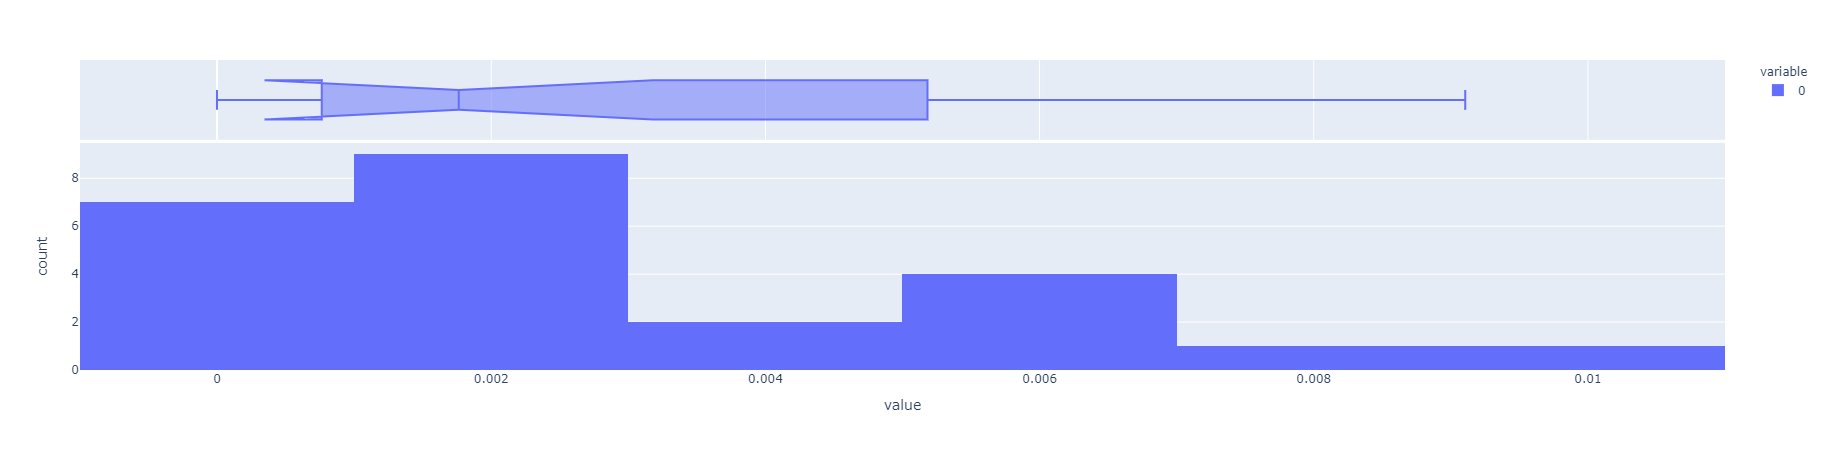

In [8]:
import plotly.express as px
feature_idx = 0
fig = px.histogram([item[feature_idx] for item in intersection_matrix], marginal="box", nbins=5)
fig.show()
# intersection_matrix

In [9]:
def max_over_diag(mat):
    up_tri = np.triu(mat)
    low_tri = np.tril(mat)
    
    up_mask = (up_tri==np.maximum(up_tri, low_tri.T)).astype(int)
    low_mask = (low_tri.T==np.maximum(up_tri, low_tri.T)).astype(int)

    maxed_adj = (up_tri*up_mask)+(low_tri.T*low_mask).T

    return maxed_adj

def zero_under_t(mat, threshold):
    mask = (mat>threshold).astype(int)
    thresholded_mat=mat*mask
    return thresholded_mat

maxed_adj = zero_under_t(max_over_diag(intersection_matrix),0.005)
G1 = nx.from_numpy_matrix(maxed_adj,create_using=nx.DiGraph, parallel_edges=False)

from pyvis import network as net

mapping = dict(zip(G1, x.columns))
G2 = nx.relabel_nodes(G1, mapping) 

g=net.Network(notebook=True, width='100%', height='800px', directed=True)
g.from_nx(G2)
g.show("G1.html")
for n in g.nodes:
    n.update({'physics': False})

g.show('with_edges_and_physics.html')

In [12]:

maxed_adj = zero_under_t(max_over_diag(intersection_matrix),0.006)
G1 = nx.from_numpy_matrix(maxed_adj,create_using=nx.DiGraph, parallel_edges=False)

from pyvis import network as net

mapping = dict(zip(G1, x.columns))
G2 = nx.relabel_nodes(G1, mapping) 

g=net.Network(notebook=True, width='100%', height='800px', directed=True)
g.from_nx(G2)
g.show("G1.html")
for n in g.nodes:
    n.update({'physics': False})

g.show("G1.html")


In [25]:
maxed_adj = zero_under_t(max_over_diag(intersection_matrix),0.01)
print(np.sum(np.array(maxed_adj) > 0))
G1 = nx.from_numpy_matrix(maxed_adj,create_using=nx.DiGraph, parallel_edges=False)

from pyvis import network as net

mapping = dict(zip(G1, x.columns))
G2 = nx.relabel_nodes(G1, mapping) 

g=net.Network(notebook=True, width='100%', height='800px', directed=True)
g.from_nx(G2)
g.show("G1.html")
for n in g.nodes:
    n.update({'physics': False})

g.show("G1.html")

23


In [ ]:
import seaborn as sns
cm = sns.light_palette("#003E74", as_cmap=True)
x=pd.DataFrame(maxed_adj).round(3)
x=x.style.background_gradient(cmap=cm, low=-0.1, high=0.01).format("{:.3}")
display(x)

In [10]:
castle.pred(X_test)[:20]

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.00039843],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.00039843],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]], dtype=float32)

In [11]:
y_test[:20]

4912    0
442     1
3852    0
5586    0
2460    0
8066    0
9379    0
5360    1
3498    0
776     0
1861    1
7467    1
1355    0
766     0
3422    0
8717    0
5105    0
4977    0
8347    0
6723    1
Name: RiskPerformance, dtype: uint8

In [12]:
pd.DataFrame(castle.pred_W1(X_DAG, y_DAG))

AttributeError: 'CASTLE' object has no attribute 'pred_W1'

In [9]:
pd.DataFrame(castle.pred_W0(X_DAG, y_DAG)[0])
# pd.DataFrame(castle.pred_W0(X_DAG, y_DAG)[1])

AttributeError: 'CASTLE' object has no attribute 'pred_W0'

In [14]:
pd.DataFrame(castle.pred_Wout(X_DAG, y_DAG)[0])

,0
0,-2.627359
1,2.338418
2,2.073921
3,-0.729244
4,-0.972286
5,-0.807146
6,-0.825919
7,-3.558019
8,0.217195
9,-1.866938


In [178]:
idx = 131
X_test.loc[idx]

RiskPerformance                         1
ExternalRiskEstimate                   59
MSinceOldestTradeOpen                 131
MSinceMostRecentTradeOpen               7
AverageMInFile                         81
NumSatisfactoryTrades                  13
NumTrades60Ever2DerogPubRec             1
NumTrades90Ever2DerogPubRec             0
PercentTradesNeverDelq                 69
MSinceMostRecentDelq                    5
MaxDelq2PublicRecLast12M                4
MaxDelqEver                             5
NumTotalTrades                         17
NumTradesOpeninLast12M                  1
PercentInstallTrades                   50
MSinceMostRecentInqexcl7days           -7
NumInqLast6M                            2
NumInqLast6Mexcl7days                   2
NetFractionRevolvingBurden             75
NetFractionInstallBurden               -8
NumRevolvingTradesWBalance              3
NumInstallTradesWBalance                2
NumBank2NatlTradesWHighUtilization      1
PercentTradesWBalance             

In [179]:
X_test.index.get_loc(idx)

325

In [229]:
pd.DataFrame(castle.pred_W0(X_DAG, y_DAG)[0]).sum().round(4)

0    0.0000
1   -0.0216
2   -0.0038
3    0.0008
4    0.0709
5   -0.0225
6    0.0037
7   -0.0166
8   -0.0032
9   -0.0613
dtype: float32

In [187]:
pd.DataFrame(castle.pred_W0(X_DAG, y_DAG)[0]*np.expand_dims(X_test_scaled[X_test.index.get_loc(idx)],-1))

,0,1,2,3,4,5,6,7,8,9
0,0.000000e+00,0.000000,0.000000,-0.000000e+00,-0.000000,-0.000000,0.000000,-0.000000,0.000000e+00,-0.000000
1,-6.127770e-39,-0.003008,-0.003015,5.746723e-39,-0.027375,-0.002384,-0.000399,0.002170,1.297350e-03,-0.001299
2,-0.000000e+00,-0.000638,-0.000799,-0.000000e+00,-0.003005,-0.000296,0.000056,0.000611,2.342940e-04,-0.002552
3,-0.000000e+00,-0.000067,-0.000166,-0.000000e+00,0.000270,-0.000060,-0.000153,0.000251,1.365379e-04,0.000815
4,0.000000e+00,0.000557,0.000605,0.000000e+00,0.002210,0.000450,0.000254,-0.000472,-3.120043e-04,0.001122
5,0.000000e+00,-0.000482,-0.001283,0.000000e+00,-0.001776,0.000228,-0.000564,0.001655,3.428072e-04,-0.000642
6,0.000000e+00,-0.000256,0.000243,0.000000e+00,-0.001985,-0.000138,0.000212,-0.000808,-6.327512e-04,-0.002418
7,0.000000e+00,-0.000047,0.000006,0.000000e+00,-0.000336,-0.000011,0.000029,-0.000074,-8.174554e-05,-0.000510
8,-0.000000e+00,0.000356,0.000181,0.000000e+00,-0.007555,0.000357,0.000926,0.000057,-3.500561e-04,-0.001050
9,-0.000000e+00,0.000145,-0.000017,-0.000000e+00,-0.000151,0.000161,-0.000021,0.000190,2.479415e-05,-0.000133


In [188]:
pd.DataFrame(np.sum(castle.pred_W0(X_DAG, y_DAG)[0]*
                    np.expand_dims(X_test_scaled[X_test.index.get_loc(idx)],-1)
                    ,axis=0
                   )+
             castle.pred_W0(X_DAG, y_DAG)[1]
            )

,0
0,-0.067018
1,0.489335
2,0.576586
3,-0.186910
4,-0.032331
5,0.260914
6,0.287168
7,0.090178
8,0.166781
9,0.243935


In [222]:
# pd.DataFrame(
o_0 = np.matmul(X_test_scaled[X_test.index.get_loc(idx)],castle.pred_W0(X_DAG, y_DAG)[0])+ castle.pred_W0(X_DAG, y_DAG)[1]
o_0

array([-0.06701823,  0.48933517,  0.57658559, -0.18690997, -0.03233091,  0.26091376,  0.28716767,  0.09017814,  0.16678087,  0.24393487])

In [223]:
np.maximum(o_0, 0, o_0)

array([0.        , 0.48933517, 0.57658559, 0.        , 0.        , 0.26091376, 0.28716767, 0.09017814, 0.16678087, 0.24393487])

In [225]:
o_1 = np.matmul(np.maximum(o_0, 0, o_0),castle.pred_W1(X_DAG, y_DAG)[0])+castle.pred_W1(X_DAG, y_DAG)[1]
o_1

array([-0.20496344,  0.96171019,  0.81930519,  0.67400853,  1.20627392, -1.41311879,  0.33510183, -0.25236285,  1.74878941,  0.33755456])

In [226]:
o_out = np.matmul(np.maximum(o_1, 0, o_1),np.array([a[0] for a in castle.pred_Wout(X_DAG, y_DAG)[0]])             
               )+castle.pred_Wout(X_DAG, y_DAG)[1][0]
o_out

1.6072144824288692

In [227]:
import math

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

sigmoid(np.sum(o_out))


0.8330242946957727

In [207]:
castle.pred(X_test_scaled)[X_test.index.get_loc(idx)]

array([0.83302426], dtype=float32)